**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ sklearn 0.20.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [2]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [4]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Предобработка данных

#### Обучение и отложенный тест

In [6]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [7]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [8]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [9]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [10]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [11]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [14]:
binary_data_columns = ['holiday', 'workingday']
#проходя по всем столбцам мы сможем сказать бинарный ли этот признак
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [15]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [16]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [17]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [18]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [19]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [21]:
#создаем модель
regressor = linear_model.SGDRegressor(random_state = 0,  loss = 'squared_loss', penalty = 'l2')

In [22]:
#FeatureUnion помогает разделить данные на несколько частей а потом собрать их вместе
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [23]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x7fe5470066a8>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
         

In [24]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.12233159059716

### Подбор параметров

In [25]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__verbose', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__check_inverse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__pass_y', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 

In [26]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [27]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [28]:
%%time
grid_cv.fit(train_data, train_labels)

CPU times: user 2.13 s, sys: 39.3 ms, total: 2.17 s
Wall time: 2.17 s


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feature_processing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(accept_sparse=False,
                                                                                            check_inverse=True,
                                                                                            func=<function <lambda> at 0x7fe5470066a8>,
                                                                                            inv_kw_args=None,
                                                                                            inverse_func=None,
                                                                                          

In [29]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-116.4878522646238
{'model_fitting__alpha': 0.001, 'model_fitting__eta0': 0.001}


### Оценка по отложенному тесту

In [30]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [31]:
metrics.mean_absolute_error(test_labels, test_predictions)

121.75239847538599

In [32]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [33]:
print(test_predictions[:20])

[155.67959986 179.4836932  221.14210678 251.18389138 266.93348132
 285.43004236 286.63458583 313.56642009 317.81313053 328.36793261
 326.21651005 318.81768982 302.82901283 287.56921897 277.957422
 246.70917637 252.29996815  69.82198701  76.9639296   84.10587219]


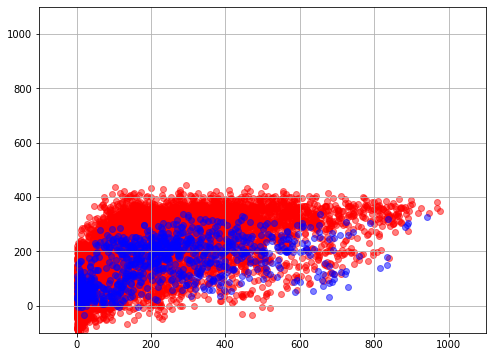

In [34]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [ ]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [ ]:
estimator.fit(train_data, train_labels)

In [ ]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

In [ ]:
test_labels[:10]

In [ ]:
estimator.predict(test_data)[:10]

In [ ]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')